Hunter Bennett | Glass Lab | Kupffer Strains Project | 15 April 2021

This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks annotated with H3K27Ac ChIP-seq data (or other histone modified data) from three strains (c57, balb, and aj) and compares each strain to the other pairwise. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [3]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

In [4]:
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_peaks_merged.txt')

In [5]:
mat.columns

Index(['/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ1_TDT_l20210213_GTAGAGAG_CTATTAAG_S11_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ2_TDT_l20210213_CAGCCTCG_AAGGCTAT_S12_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ3_TDT_l20210213_TGCCTCTT_GAGCCTTA_S13_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ4_TDT_l20210213_TCCTCTAC_TTATGCGA_S14_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB1_TDT_l20210213_TCATGAGC_CTCTCTAT_S15_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/

In [6]:
best_reps = [
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ1_TDT_l20210213_GTAGAGAG_CTATTAAG_S11_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ2_TDT_l20210213_CAGCCTCG_AAGGCTAT_S12_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ3_TDT_l20210213_TGCCTCTT_GAGCCTTA_S13_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_aj_Male_Kupffer_ATAC_Chow_healthyoung_AJ4_TDT_l20210213_TCCTCTAC_TTATGCGA_S14_L001_trim30.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB1_TDT_l20210213_TCATGAGC_CTCTCTAT_S15_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB2_TDT_l20210213_CCTGAGAT_TATCCTCT_S16_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB3_TDT_l20210213_TAGCGAGT_GTAAGGAG_S17_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB4_TDT_l20210213_GTAGCTCC_ACTGCATA_S18_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C571_TDT_l20210213_TACTACGC_AAGGAGTA_S19_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C572_TDT_l20210213_AGGCTCCG_CTAAGCCT_S20_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C573_TDT_l20210213_GCAGCGTA_CGTCTAAT_S21_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/tag_mouse_c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C574_TDT_l20210213_CTGCGCAT_TCTCTCCG_S22_L001_trim30']

In [7]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_peaks_merged.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt', sep='\t')

### Import differential peaks

In [8]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt \
# aj aj aj aj \
# balbcj balbcj balbcj balbcj \
# c57bl6j c57bl6j c57bl6j c57bl6j \
# -AvsA -peaks > ./merged_peaks/diff_output.txt


In [9]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_idr_peaks_merged.txt')

annotatePeaks all peaks (86301, 30)
getDiffExpression selected transcripts (84264, 39)
annotatePeaks selected peaks (84264, 30)


In [10]:
# pull out selected samples
cols = np.append(np.asarray([True]*18, 'bool'), peak_mat.columns.str.contains('|'.join(best_reps)))
peaks = peaks.loc[:, tst]
peak_mat = peak_mat.loc[:, peak_mat.columns.str.contains('|'.join(best_reps))]

In [11]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [12]:
comp_dict.keys()

dict_keys(['aj vs. balbcj', 'aj vs. c57bl6j', 'balbcj vs. c57bl6j'])

In [13]:
comps = ['aj vs. balbcj',
         'aj vs. c57bl6j',
         'balbcj vs. c57bl6j']

groups = [[[0,1,2,3],[4,5,6,7]],
         [[0,1,2,3],[8,9,10,11]],
         [[4,5,6,7],[8,9,10,11]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)

colors = [['#e41a1c', '#377eb8'],
          ['#e41a1c', '#4daf4a'],
          ['#377eb8', '#4daf4a']]

In [13]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < 0)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 0)))
    print('')
#     fig, axs = plt.subplots(1, 2, figsize=(10,6))
#     plt.subplots_adjust(wspace=0.5)

#     axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
#                 right=np.ceil(np.max(np.abs(de.log2fc))))
#     axs[0].scatter(
#         x=de.log2fc,
#         y=de.logtpm,
#         s=dot_sizes, #de.log10p+0.05,
#         c=dot_colors)

#     axs[0].set_ylabel('Mean Log2(TPM)')
#     axs[0].set_xlabel('Log2FC')

#     # plot group by group scatter:
#     axs[1].scatter(
#         x=de.g0_mean,
#         y=de.g1_mean,
#         s=dot_sizes, #de.log10p+0.05,
#         c=dot_colors)
    
#     axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
#     axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
#     #set max and min
#     countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
#     axs[1].set_xlim([0,np.ceil(countmax)])
#     axs[1].set_ylim([0,np.ceil(countmax)])
                      
#     plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
#     plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,12.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(12.5,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    plt.close()

aj vs. balbcj
N genes downregulated 1685
N genes upregulated 2463

aj vs. c57bl6j
N genes downregulated 4049
N genes upregulated 3706

balbcj vs. c57bl6j
N genes downregulated 4919
N genes upregulated 3927



# Cluster differential enhancers:
____
### All enhancers

5693


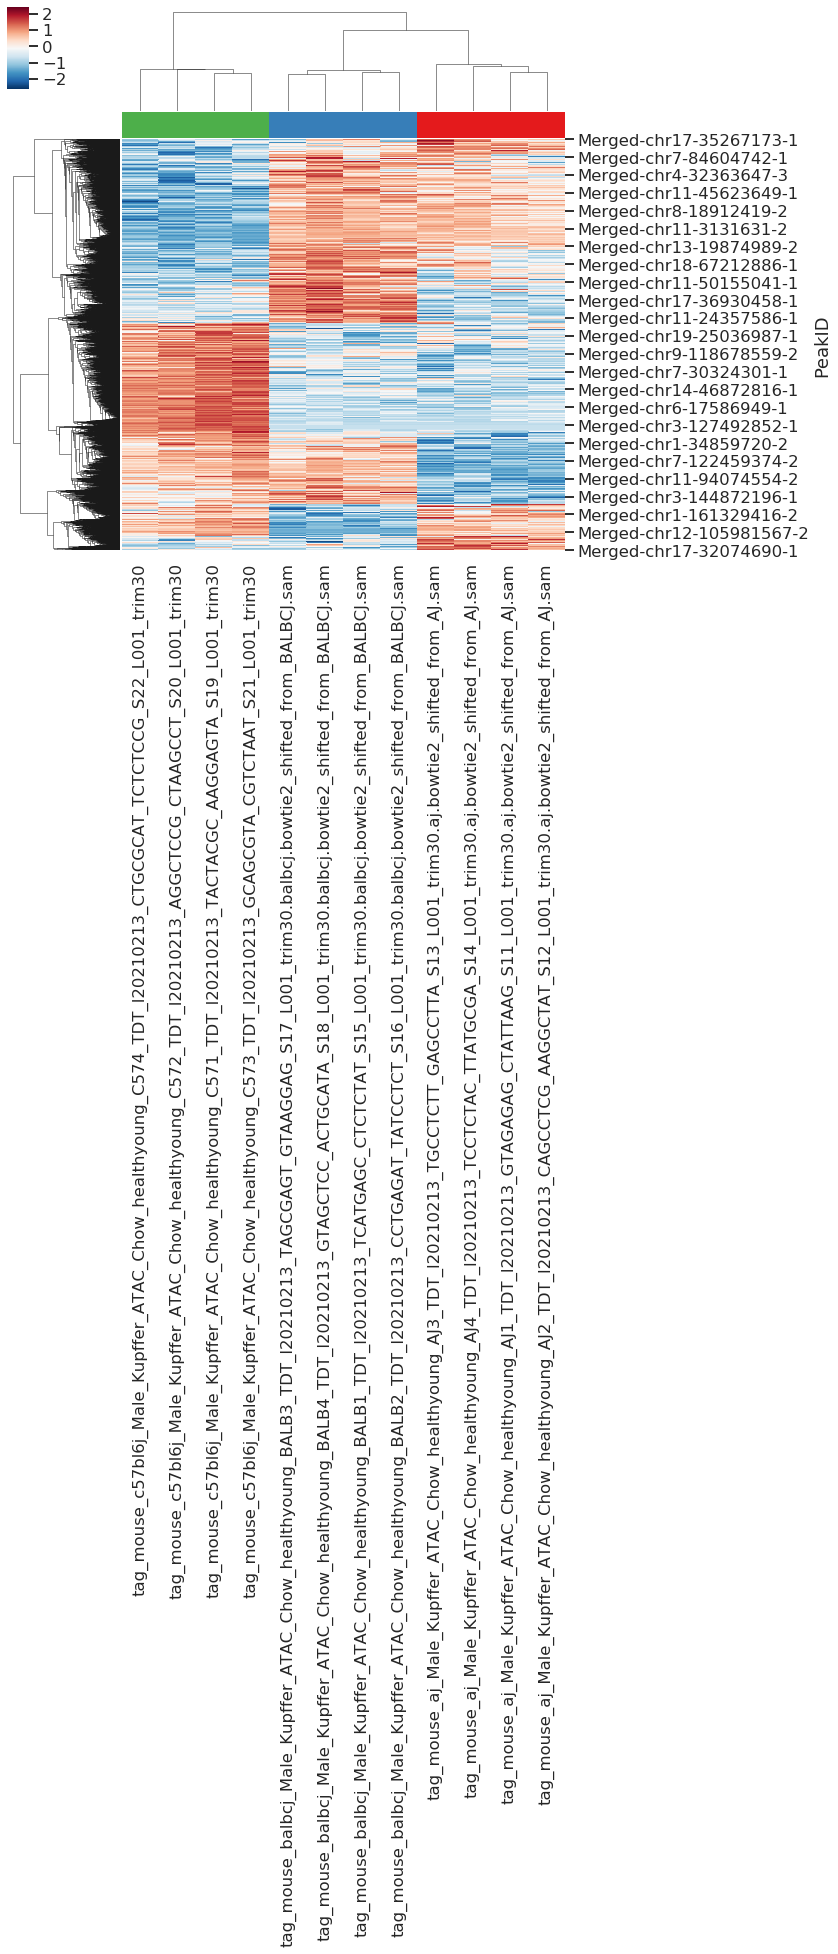

In [14]:
pval = 0.05
fc = 2

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c',
                           '#377eb8', '#377eb8', '#377eb8', '#377eb8',
                           '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a'])
plt.savefig('./figures/diff_peaks_clustermap.png', bbox_inches='tight')

### distal enhancers only

4942


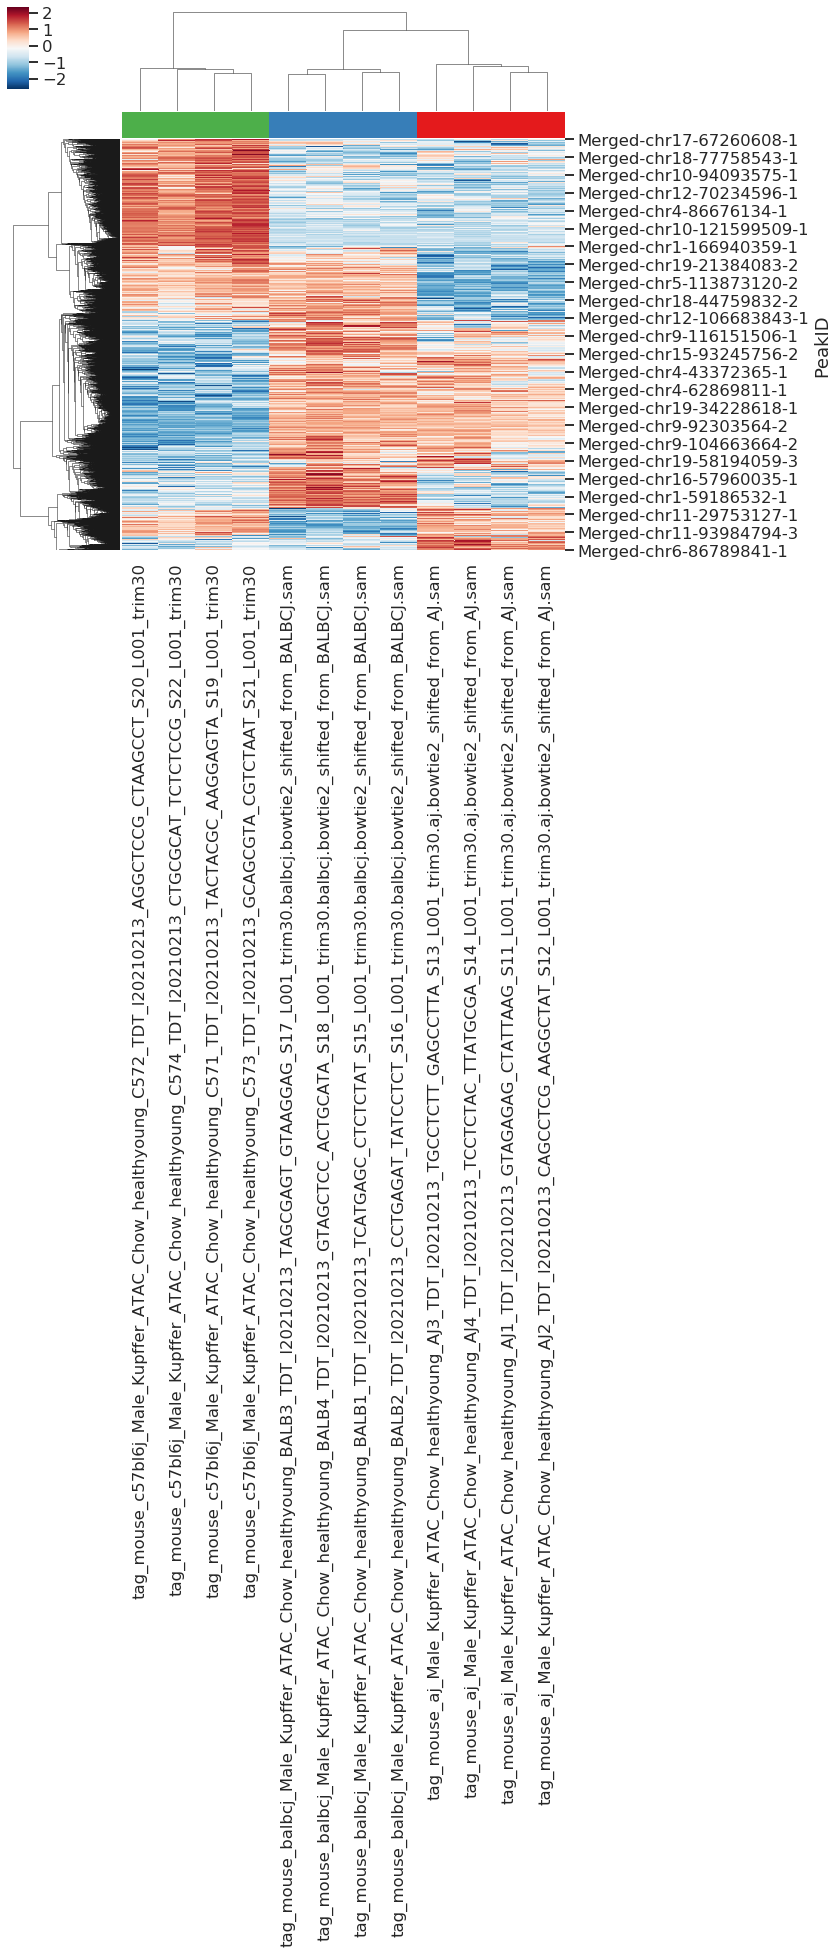

In [15]:
pval = 0.05
fc = 2

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c',
                           '#377eb8', '#377eb8', '#377eb8', '#377eb8',
                           '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a'])
plt.savefig('./figures/diff_peaks_distal_clustermap.png', bbox_inches='tight')

# Save differential peaks for analysis in GREAT

In [16]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

In [25]:
comp_dict.keys()
key = 'aj vs. balbcj'

In [36]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['aj',
         'balbcj',
         'c57bl6j']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)
        print(key)
        # store pairwise differential
        # strain 1
        pairwise_key = key.replace(' vs. ', '_vs_')+'_'+key.split(' vs. ')[0]+'_up'
        sig_peaks = df.index[(df['adj_pval'] < pval) & (df['log2fc'] <= -fc)].to_list()
        peak_lists[pairwise_key] = list(sig_peaks)
        # strain 2
        pairwise_key = key.replace(' vs. ', '_vs_')+'_'+key.split(' vs. ')[1]+'_up'
        sig_peaks = df.index[(df['adj_pval'] < pval) & (df['log2fc'] >= fc)].to_list()
        peak_lists[pairwise_key] = list(sig_peaks)

        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing aj ...

0
aj vs. balbcj
For comp: aj vs. balbcj
Union set at: 1386 peaks
Intersection set at: 1386 peaks

1
aj vs. c57bl6j
For comp: aj vs. c57bl6j
Union set at: 3871 peaks
Intersection set at: 593 peaks

2
balbcj vs. c57bl6j
For comp: balbcj vs. c57bl6j
Union set at: 3871 peaks
Intersection set at: 593 peaks

Analyzing balbcj ...

0
aj vs. balbcj
For comp: aj vs. balbcj
Union set at: 2174 peaks
Intersection set at: 2174 peaks

1
aj vs. c57bl6j
For comp: aj vs. c57bl6j
Union set at: 2174 peaks
Intersection set at: 2174 peaks

1
balbcj vs. c57bl6j
For comp: balbcj vs. c57bl6j
Union set at: 5468 peaks
Intersection set at: 790 peaks

Analyzing c57bl6j ...

0
aj vs. balbcj
For comp: aj vs. balbcj
Union set at: 5468 peaks
Intersection set at: 790 peaks

0
aj vs. c57bl6j
For comp: aj vs. c57bl6j
Union set at: 3100 peaks
Intersection set at: 3100 peaks

1
balbcj vs. c57bl6j
For comp: balbcj vs. c57bl6j
Union set at: 4654 peaks
Intersection set at: 1550 peaks



if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [42]:
convert_dict = {'Start': int,
                'End': int}

for key in peak_lists.keys():
    # save cell specific promoters
    tmp = diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./great_analysis/peak_files/'+key+'_poised_peaks.txt',
               sep='\t')

Save full set of peaks for background

In [19]:
diff_peak.iloc[:, :4].to_csv(
    './great_analysis/peak_files/all_peaks.txt',
    sep='\t')

Convert peaks to bed file

In [20]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

In [21]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [22]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [23]:
!cp ./great_analysis/bed_files/* ./bed_files/

In [24]:
!ls ./bed_files/

aj_intersection_poised_peaks.bed      balbcj_union_poised_peaks.bed
aj_union_poised_peaks.bed	      c57bl6j_intersection_poised_peaks.bed
all_peaks.bed			      c57bl6j_union_poised_peaks.bed
balbcj_intersection_poised_peaks.bed


In [25]:
with open('./label_bed.sh', 'w') as f:
    for i in glob.glob('./bed_files/*poised_peaks.bed*'):

        strain = i.split('/')[-1].split('_')[0]
        settype = i.split('/')[-1].split('_')[1]
        group = "Control_Young"
        chip = 'ATAC'

        # set track names for upload to ucsc genome browser
        lab = "'track name=\"%s_%s_%s_%s\" description=\"%s %s %s %s DESeq2\"'" % (strain, chip, group, settype, strain, group, chip, settype)
        lab_dist = "'track name=\"%s_%s_%s_%s_distal\" description=\"%s %s %s %s DESeq2\"'" % (strain, chip, group, settype, strain, group, chip, settype)

        # set labels - can't think of a more clever way to do this so we will just
        # use the simple if / else statement to switch labels depending on our 
        # peak set being distal or all
        
        if 'distal' in i:
            l = lab_dist
        else:
            l = lab
        
        label_track = ['echo', l, '|', 'cat', '-',
                       i,
                       '> temp && mv temp',
                       i, '\n']
    
        f.write(' '.join(label_track))
        
    f.close()

label all peaks post-hoc

In [26]:
%%bash

echo 'track name="kupffer_control_young_atac_merged" description="Kupffer Young Control ATAC All Strains"' \
| cat - ./bed_files/all_peaks.bed \
> temp && mv temp ./bed_files/all_peaks.bed

# Check differential peak quality in browser

In [27]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [28]:
diff_peak.columns[30:]

Index(['aj vs. balbcj Log2 Fold Change', 'aj vs. balbcj p-value',
       'aj vs. balbcj adj. p-value', 'aj vs. c57bl6j Log2 Fold Change',
       'aj vs. c57bl6j p-value', 'aj vs. c57bl6j adj. p-value',
       'balbcj vs. c57bl6j Log2 Fold Change', 'balbcj vs. c57bl6j p-value',
       'balbcj vs. c57bl6j adj. p-value', 'location'],
      dtype='object')

In [31]:
diff_peak.sort_values('aj vs. balbcj adj. p-value', ascending=True).head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,aj vs. balbcj Log2 Fold Change,aj vs. balbcj p-value,aj vs. balbcj adj. p-value,aj vs. c57bl6j Log2 Fold Change,aj vs. c57bl6j p-value,aj vs. c57bl6j adj. p-value,balbcj vs. c57bl6j Log2 Fold Change,balbcj vs. c57bl6j p-value,balbcj vs. c57bl6j adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr1-121462918-2,chr1,121462802,121463002,+,1000.0,./atac_peak_files/aj_kupffer_control_young.idr...,"intron (NM_029955, intron 10 of 23)","intron (NM_029955, intron 10 of 23)",31835.0,NM_029955,...,-5.065209,1.821132e-70,1.533193e-65,-1.004995,9.991692e-08,5.954243e-06,4.041539,2.124482e-40,8.136960e-37,chr1:121462802-121463002
Merged-chr15-25563403-1,chr15,25563303,25563503,+,1000.0,./atac_peak_files/aj_kupffer_control_young.idr,Intergenic,Intergenic,-59147.0,NM_019472,...,-7.733965,3.295889e-57,1.387388e-52,-7.511238,4.602716e-24,6.156940e-21,0.261537,8.497471e-01,9.474844e-01,chr15:25563303-25563503
Merged-chr6-8059412-1,chr6,8059312,8059512,+,1000.0,./atac_peak_files/aj_kupffer_control_young.idr,"intron (NM_001037865, intron 26 of 34)","intron (NM_001037865, intron 26 of 34)",133205.0,NM_001037865,...,-6.607501,1.756673e-56,4.929751e-52,-7.962763,2.220238e-20,1.655610e-17,-1.036715,4.934385e-01,7.720525e-01,chr6:8059312-8059512
Merged-chr4-119177920-2,chr4,119177806,119178006,+,1000.0,./atac_peak_files/aj_kupffer_control_young.idr...,"3' UTR (NM_013848, exon 13 of 13)","3' UTR (NM_013848, exon 13 of 13)",-3711.0,NM_001145936,...,-5.654365,5.384469e-52,1.133283e-47,-0.235218,2.666800e-01,6.128741e-01,5.402205,6.047031e-51,6.369187e-47,chr4:119177806-119178006
Merged-chr8-57504974-1,chr8,57504874,57505074,+,1000.0,./atac_peak_files/aj_kupffer_control_young.idr,promoter-TSS (NR_126556),promoter-TSS (NR_126556),-841.0,NR_126556,...,-6.632954,1.977774e-50,3.330137e-46,-7.128035,8.679770e-21,6.648941e-18,-0.549834,7.081669e-01,8.875790e-01,chr8:57504874-57505074


### Notes:
* Top peak at chr1:24612645-24612845 is an artefact from sequencing